# Traveling Salesman Problem (TSP)

In [163]:
using Pkg
Pkg.activate(".")

import Base.show

using LinearAlgebra
using Printf
using Random

using Gurobi
if !isdefined(Main, :GRBENV)
    const GRBENV = Gurobi.Env()
end

using GLPK
using JuMP

using Plots
import Plots.plot

  Activating environment at `~/Git/or_tutorials/callbacks/Project.toml`


Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-30


## Problem formulation

We have $N$ cities to visit.
Each city must be visited exactly once, and we must return to the origin at the end of the trip.
We want the shortest tour.

Notations:
* $x_{i, j} = 1$ if city $j$ follows city $i$ in the tour, and zero otherwise
* $D_{i, j}$ is the (euclidean) distance between cities $i$ and $j$

Mathematical formulation:
\begin{align}
    \min_{x} \quad
      & \sum_{i, j} D_{i, j} x_{i, j}\\
      \text{s.t.} \quad
      & x_{i, i} = 0, 
          && \forall i \in \mathcal{N},\\
      & \sum_{j \in \mathcal{N}} x_{i, j} = 1, 
          && \forall i \in \mathcal{N},\\
      & \sum_{i \in \mathcal{N}} x_{i, j} = 1, 
          && \forall j \in \mathcal{N},\\
      & \sum_{i \in \mathcal{S}, j \in \mathcal{S}} x_{i, j} \leq |\mathcal{S}| - 1, 
          && \forall \mathcal{S} \subseteq \mathcal{N}, 2 \leq |\mathcal{S}| \leq N-1\\
      & x_{i, j} \in \{0, 1\}, 
          && \forall i, j \in \mathcal{N}^{2}
\end{align}

Constraints $\sum_{i \in \mathcal{S}, j \in \mathcal{S}} x_{i, j} \leq |\mathcal{S}| - 1$ are _subtour elimination constraints_

⚠️ There are exponentially many subtours! ⚠️

## Problem setup

In [138]:
struct TSPData
    N::Int
    X::Matrix{Float64}
    D::Matrix{Float64}
end

Base.show(io::IO, data::TSPData) = print(io, "TSP data with $(data.N) cities")

function Plots.plot(data::TSPData;
    title="TSP locations (N=$(data.N) cities)",
    legend=false,
    xlim=(0,1),
    ylim=(0,1),
    aspect_ratio=1,
    kwargs...
)
    plt = scatter(
        data.X[:, 1],
        data.X[:, 2];
        title,
        legend,
        xlim,
        ylim,
        aspect_ratio,
        kwargs...
    )
    return plt
end

In [27]:
function generate_tsp_data(N; seed=42)
    Random.seed!(seed)
    
    # Sample coordinates in the [0, 1]×[0, 1] square
    X = rand(N, 2)
    
    # Compute Euclidean distances
    D = zeros(N, N)
    for i in 1:N
        xᵢ = X[i, :]
        for j in (i+1):N
            xⱼ = X[j, :]
            # Euclidean distances
            D[i, j] = D[j, i] = norm(xᵢ - xⱼ, 2)
        end
    end
    
    return TSPData(N, X, D)
end

generate_tsp_data (generic function with 1 method)

We provide:
* `TSPData` structure that contains distance matrix
* `generate_stp_data` to generate random data

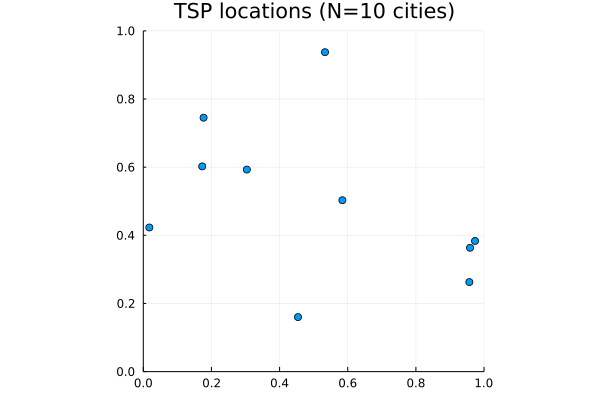

In [139]:
data10 = generate_tsp_data(10)
plot(data10)

In [29]:
function extract_tour(x)
    n = size(x, 1)
    size(x, 1) == size(x, 2) || error("x must be square")
    
    # `t[i]` is the city that follows `i` in the tour
    t = zeros(Int, n)
    @inbounds for j in 1:n
        for i in 1:n
            x[i, j] == 1.0 && (t[i] = j; break;)
        end
    end
    
    flags = falses(n)
    for i in t
        flags[i] = true
    end
    all(flags) || error("City $(argmin(flags)) is not visited")
    
    return t
end

"""
    find_subtours(x)
Compute sub-tours from tentative tour `x`.
"""
function find_subtours(t)
    n = length(t)
    # List of all sub-tours in `t`
    # Will be empty if `t` is a tour
    subtours = Vector{Int}[]

    flags = falses(n)
    num_seen = 0
    while num_seen < n
        first = argmin(flags)  # first city in current tour
        flags[first] && break  # all cities have been visited
        subtour = [first]
        flags[first] = true
        num_seen += 1
        next = t[first]
        next == first && error("City $(first) is its self-successor.")
        while next != first
            push!(subtour, next)
            flags[next] = 1
            num_seen += 1
            next = t[next]
        end

        length(subtour) == n && (return [subtour])  # x is a tour
        push!(subtours, subtour)
    end
    
    return subtours
end

find_subtours

In [143]:
function plot_tour(data::TSPData, tour;
    title="",
    legend=false,
    xlim=(0,1),
    ylim=(0,1),
    aspect_ratio=1,
    kwargs...
)
    plt = plot(data; title, legend, xlim, ylim, aspect_ratio, kwargs...)
    
    X = data.X
    
    subtours = find_subtours(tour)

    for st in subtours
        S = length(st)
        for k in 1:S
            iₖ = st[1 + (k % S)]
            jₖ = st[1 + ((k+1)%S)]
            plot!(plt,
                [X[iₖ, 1], X[jₖ, 1]],
                [X[iₖ, 2], X[jₖ, 2]],
                label=nothing,
                color=:black,
            )
        end
    end
    return plt
end

plot_tour (generic function with 2 methods)

## Cut separation

Given a tentative tour
1. Identify individual sub-tours
2. Add subtour elimination constraint

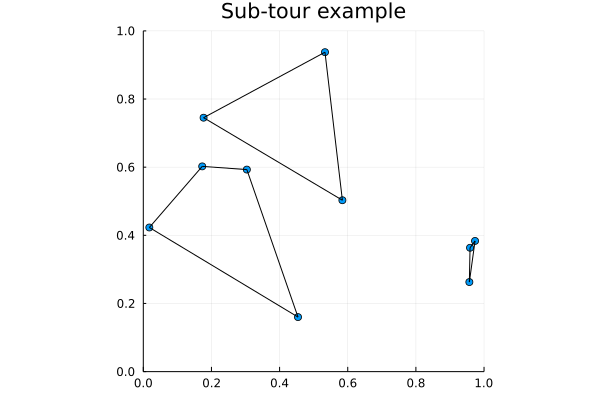

In [157]:
example_tour = [8, 3, 4, 7, 6, 9, 2, 10, 5, 1]
plot_tour(data10, example_tour; title="Sub-tour example")

## Solving iteratively

1. Build the MIP without subtour constraints
2. Solve the MIP, get the current solution
3. Does the solution have subtours?
    1. No: done
    2. Yes: add subtour elimination constraints and go to 2.

Pros
* No callback to implement
* No restriction on what you can and cannot do

Cons
* Typically slower
* Only the last solution is feasible!

In [193]:
function solve_tsp_iterative(data::TSPData)
    t_start = time()
    
    # Grab TSP data
    N = data.N
    X = data.X
    D = data.D
    
    # Build TSP model
    tsp = direct_model(Gurobi.Optimizer(GRBENV))

    @variable(tsp, x[1:N, 1:N], Bin)

    @constraint(tsp, no_self[i in 1:N], x[i, i] == 0)
    @constraint(tsp, arcs_in[j in 1:N], sum(x[:, j]) == 1)
    @constraint(tsp, arcs_out[i in 1:N], sum(x[i, :]) == 1)

    @objective(tsp, Min, sum(D .* x))

    # Iterative constraint generation
    solved = false
    niter = 0

    tours = []  # This will record all the solutions we see
    
    println("Solving a TSP with $(N) cities\n")
    
    @printf "%4s  %4s  %6s\n" "Iter" "#ST" "Time"
    while !solved && (niter < 30)
        niter += 1

        set_silent(tsp)
        optimize!(tsp)
        x_ = round.(value.(x));

        tour = extract_tour(x_)
        subtours = find_subtours(tour)

        t_elapsed = time() - t_start
        @printf "%4d  %4d  %6.2f\n" niter length(subtours) t_elapsed
        
        push!(tours, (t_elapsed, tour))

        if length(subtours) == 1
            solved = true
            println("TSP Solved at iteration $niter")
            break
        end

        # add cuts
        for st in subtours
            S = length(st)
            @constraint(tsp, 
                sum(x[st[1 + (k % S)], st[1 + ((k+1)%S)]] for k in 1:S) <= S-1
            )
            @constraint(tsp, 
                sum(x[st[1 + ((k+1)%S)], st[1 + (k % S)]] for k in 1:S) <= S-1
            )
        end
    end
    
    
    z = objective_value(tsp);
    @printf "Final objective value: %.4f" z
    
    return tsp, tours
end

solve_tsp_iterative (generic function with 2 methods)

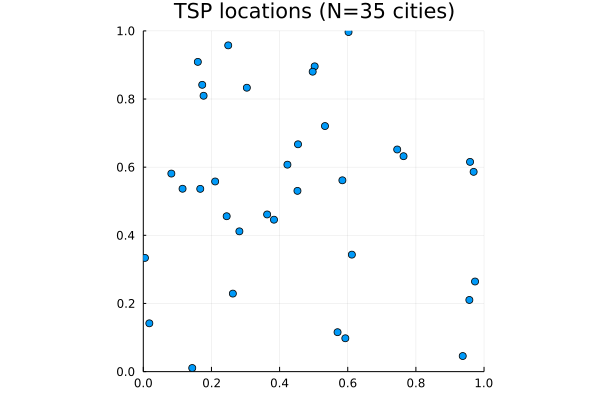

In [194]:
N = 35; data = generate_tsp_data(N)
plot(data)

In [195]:
tsp1, tours1 = solve_tsp_iterative(data);

Solving a TSP with 35 cities

Iter   #ST    Time
   1    16    0.01
   2    11    0.09
   3     7    0.26
   4     6    0.43
   5     4    0.70
   6     3    1.21
   7     4    1.63
   8     2    2.25
   9     3    3.15
  10     2    3.95
  11     1    4.73
TSP Solved at iteration 11
Final objective value: 4.8808

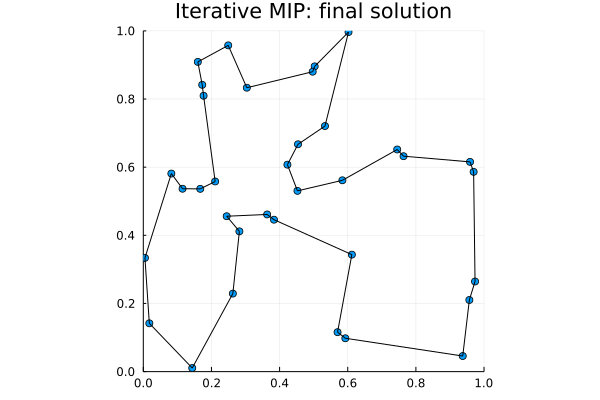

In [212]:
plot_tour(data, tours1[end][2], title="Iterative MIP: final solution")

## Using a lazy constraint callback

1. Build the MIP without subtour constraints
2. Create a callback to
    1. Find subtours (if any)
    2. Add subtour elimination constraints (lazy)
3. Register the callback
4. Call `optimize!`

Pros
* Typically faster
* Some heuristic solutions along the way

Cons
* You need to implement a callback

In [199]:
function solve_tsp_lazy(data::TSPData)
    t_start = time()

    N = data.N
    D = data.D
    
    # Build TSP model
    tsp = direct_model(Gurobi.Optimizer())

    @variable(tsp, x[1:N, 1:N], Bin)

    @constraint(tsp, no_self[i in 1:N], x[i, i] == 0)
    @constraint(tsp, arcs_in[j in 1:N], sum(x[:, j]) == 1)
    @constraint(tsp, arcs_out[i in 1:N], sum(x[i, :]) == 1)

    @objective(tsp, Min, sum(D .* x))
    
    tours = []
    
    # Define lazy callback
    function tsp_callback_lazy(cb_data)
        # Only separate cuts at integer solutions
        cb_status = callback_node_status(cb_data, tsp)
        cb_status == MOI.CALLBACK_NODE_STATUS_INTEGER || return nothing
        
        # Grab solution and extract subtours
        x_ = round.(callback_value.(cb_data, x))
        tour = extract_tour(x_)
        subtours = find_subtours(tour)
        
        t_elapsed = time() - t_start
        push!(tours, (t_elapsed, tour))
        
        length(subtours) == 1 && return nothing  # Solution is a tour
        
        # Add lazy constraints
        for st in subtours
            S = length(st)
            con1 = @build_constraint(
                sum(x[st[1 + (k % S)], st[1 + ((k+1)%S)]] for k in 1:S) <= S-1
            )
            con2 = @build_constraint(
                sum(x[st[1 + ((k+1)%S)], st[1 + (k % S)]] for k in 1:S) <= S-1
            )
            
            MOI.submit(tsp, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(tsp, MOI.LazyConstraint(cb_data), con2)
        end
        
        return nothing
    end
    
    MOI.set(tsp, MOI.LazyConstraintCallback(), tsp_callback_lazy)
    
    println("Solving a TSP with $(N) cities\n")
    
    unset_silent(tsp)
    optimize!(tsp)
    
    return tsp, tours
end

solve_tsp_lazy (generic function with 1 method)

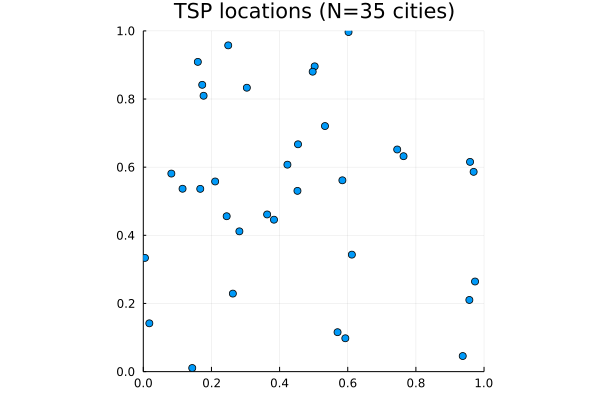

In [200]:
N = 35; data = generate_tsp_data(N)
plot(data)

In [202]:
tsp2, tours2 = solve_tsp_lazy(data);

Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-30
Set parameter LazyConstraints to value 1
Solving a TSP with 35 cities

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105 rows, 1225 columns and 2485 nonzeros
Model fingerprint: 0x0ca4ecd8
Variable types: 0 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 35 rows and 35 columns
Presolve time: 0.01s
Presolved: 70 rows, 1190 columns, 2380 nonzeros
Variable types: 0 continuous, 1190 integer (1190 binary)

Root relaxation: objective 4.138955e+00, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

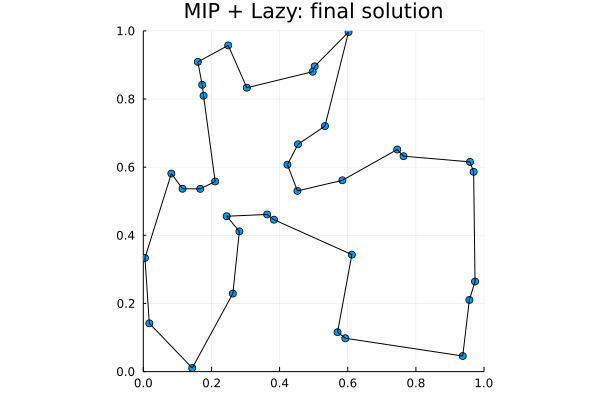

In [213]:
plot_tour(data, tours2[end][2], title="MIP + Lazy: final solution")

In [207]:
ntours1 = length(tours1)
ntours2 = length(tours2)

# We need to make sure the two GIFs will have the same number of images
# Total GIF duration should be 4s: 3s for initial solutions, and 1s for the final one
_tours1 = deepcopy(tours1)
_tours2 = deepcopy(tours2)

anim = @animate for t in 1:ntours1
    plt = plot_tour(data, tours1[t][2], title= @sprintf "TSP + Iterative; N=%d\n Time = %.2fs" N tours1[t][1])
    plt
end
gif1 = gif(anim, "tsp_iterative_$(N).gif", fps=3)

anim = @animate for t in 1:ntours2
    plt = plot_tour(data, tours2[t][2], title= @sprintf "TSP + Lazy; N=%d\n Time = %.2fs" N tours2[t][1])
    plt
end
gif2 = gif(anim, "tsp_lazy_$(N).gif", fps=8);

┌ Info: Saved animation to 
│   fn = /home/mtanneau3/Git/or_tutorials/callbacks/tsp_iterative_35.gif
└ @ Plots /home/mtanneau3/.julia/packages/Plots/tXtrW/src/animation.jl:114
┌ Info: Saved animation to 
│   fn = /home/mtanneau3/Git/or_tutorials/callbacks/tsp_lazy_35.gif
└ @ Plots /home/mtanneau3/.julia/packages/Plots/tXtrW/src/animation.jl:114


Plots.AnimatedGif("/home/mtanneau3/Git/or_tutorials/callbacks/tsp_iterative_35.gif")
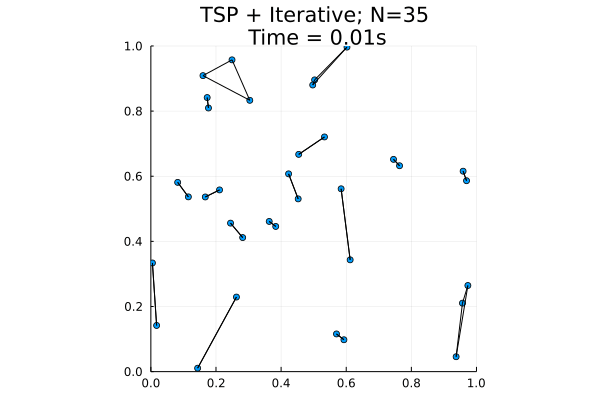

In [208]:
gif1

Plots.AnimatedGif("/home/mtanneau3/Git/or_tutorials/callbacks/tsp_lazy_35.gif")
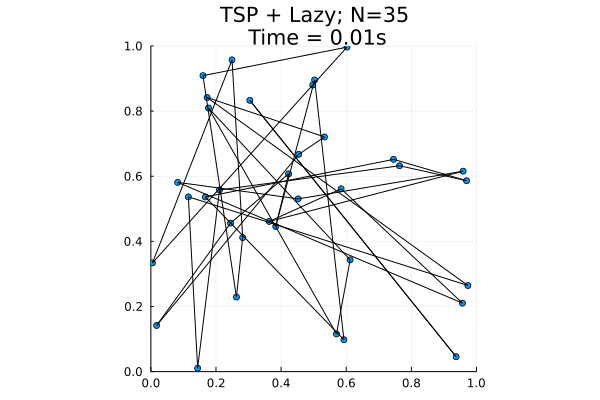

In [209]:
gif2